In [1]:
from ROOT import RDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tqdm import tqdm

from fftprep.fftprep import make_img, fft_filter, fft_filter_pairwise, reconstruct_img, complete_data_pw, load_from_sparse, fftpredictor, params_pairwise

from sklearn.neural_network import MLPRegressor

from scipy.signal import detrend

import pickle

from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from scipy.stats import crystalball
from scipy.optimize import curve_fit

In [4]:
data = RDataFrame("t;1", "FullSim_10GeV.root").AsNumpy()
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_fast, obs_fast = X[subset], obs[subset]
del X
del obs

In [26]:
data = RDataFrame("t;1", "FullSim_50GeV.root").AsNumpy()
X = np.array(
    [
        data["part_p"],
        data["part_x"], 
        data["part_y"],
        data["part_z"],
        data["part_theta"],
        data["part_phi"]
    ]
).transpose()
obs = data["cl_E_ecal"]
del data
subset = (X.transpose()[1]>500) \
            *(X.transpose()[1]<3500) \
            *(X.transpose()[2]>500) \
            *(X.transpose()[2]<2500) \
            *(X.transpose()[3]>12280) \
            *(X.transpose()[3]<12300) \
            *(X.transpose()[4]<0.6) \
            *(X.transpose()[5]<2*np.pi) \
    
X_full, obs_full = X[subset], obs[subset]
del X
del obs

In [27]:
fft_filt_data_pw = load_from_sparse(return_full=True, n_sigma = 1)

params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (0,0.6),
        "reso": 100
    }, 
    "phi": {
        "range": (0,2*np.pi),
        "reso": 10
    }
}

model = fftpredictor(fft_filt_data_pw, params)

In [28]:
preds = []
for row in tqdm(X_full):
    preds.append(model.predict((row[1], row[2], row[4], row[5]), mode="reg"))

100%|████████████████████████████| 22061469/22061469 [05:18<00:00, 69198.89it/s]


In [30]:
preds = np.array(preds)

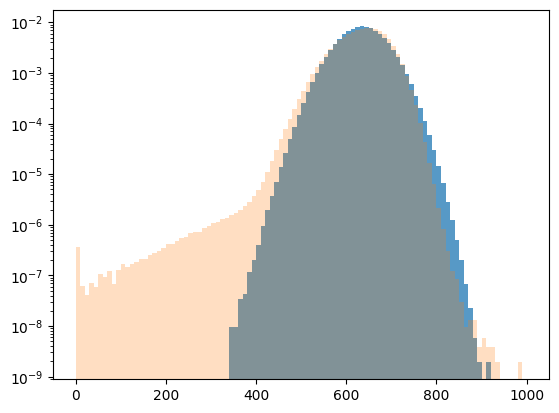

0.002861605046049164

In [494]:
#random_weights = np.random.beta(min_max_scale(preds)+0.5, 0.5)
preds_corrected = np.random.normal(preds, (1-min_max_scale(preds))**2*25+45)
pred_counts, pred_bins = np.histogram(preds_corrected, bins=100, density=True, range=(0,1000))
obs_counts, obs_bins = np.histogram(obs_full, bins=100, density=True, range=(0,1000))
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=0.75)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.25)
plt.yscale("log")
plt.show()
np.sqrt(np.sum((pred_counts-obs_counts)**2))

In [632]:
def double_cball(x, a_1,a_2, beta_1,beta_2, m_1,m_2, loc_1,loc_2, scale_1,scale_2):
    return a_1*crystalball.pdf(x,beta_1,m_1,loc_1,scale_1) + a_2*crystalball.pdf(-x,beta_2,m_2,-loc_2,scale_2)
    
obs_counts, obs_bins = np.histogram(np.log(obs_full+0.01), bins="auto")
bin_centers = obs_bins[:-1] + np.diff(obs_bins) / 2

x_interval_for_fit = np.linspace(5.8, 7, 10000)
curve_fit(double_cball, bin_centers, obs_counts, p0=[1.5 ,  3.1       ,  20, 19.        ,  6.5,
         6.6       ,  0.06232,  0.043])

(array([1.09535444, 1.64162923, 3.44223593, 1.00000001, 6.47015596,
        6.59735137, 0.06787887, 0.04952978]),
 array([[ 5.78737945e-05,  1.19597266e+01, -5.15587384e-04,
         -1.45051405e-07, -4.69232411e-07, -7.00242703e-01,
          4.21458034e-07,  9.06091547e-01],
        [ 1.19597266e+01,  8.51366279e+08, -4.45561906e+02,
         -1.61413756e+01, -9.70221092e-01, -1.11707991e+06,
         -2.87303911e-01,  3.99946148e+06],
        [-5.15587384e-04, -4.45561906e+02,  9.11779124e-03,
          1.94000268e-06,  1.11374599e-05,  2.72046294e+01,
          4.47620041e-06, -1.78891663e+01],
        [-1.45051405e-07, -1.61413756e+01,  1.94000268e-06,
          3.17899262e-07,  4.00728065e-09, -1.44616263e-02,
         -3.73666160e-09, -4.81130524e-02],
        [-4.69232411e-07, -9.70221092e-01,  1.11374599e-05,
          4.00728065e-09,  2.98926485e-08,  6.20269858e-02,
          6.95771985e-09, -3.97935892e-02],
        [-7.00242703e-01, -1.11707991e+06,  2.72046294e+01,
      

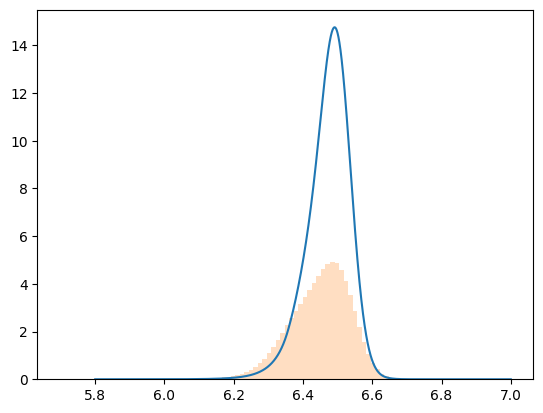

In [645]:
plt.plot(np.linspace(5.8, 7, 100000), double_cball(np.linspace(5.8, 7, 100000), 1.5 ,  3.1       ,  20, 19.        ,  6.45,
         6.5,  0.06232,  0.04))
obs_counts, obs_bins = np.histogram(np.log(obs_fast+1), bins=100, density=True)
#plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=0.75)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.25)
plt.show()

In [646]:
obs_full.shape

(52523384,)

In [244]:
grid = np.ndarray((20,20))
for i in tqdm(range(70,90)):
    for j in  range(20,40):
        pred_counts, pred_bins = np.histogram(np.random.normal(preds, (1-min_max_scale(preds))*i+j), bins=100, density=True, range=(0,1000))
        obs_counts, obs_bins = np.histogram(obs_full, bins=100, density=True, range=(0,1000))
        grid[i-70,j-20] = np.sqrt(np.sum((pred_counts-obs_counts)**2))

100%|███████████████████████████████████████████| 20/20 [09:53<00:00, 29.68s/it]


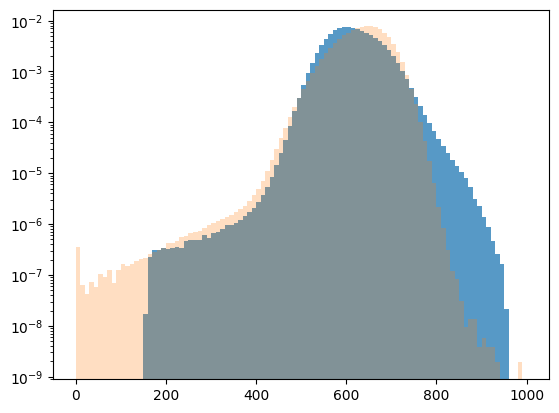

In [652]:
pred_counts, pred_bins = np.histogram(1250-obs_fast, bins=100, density=True, range=(0,1000))
obs_counts, obs_bins = np.histogram(obs_full, bins=100, density=True, range=(0,1000))
plt.hist(pred_bins[:-1], pred_bins, weights=pred_counts, alpha=0.75)
plt.hist(obs_bins[:-1], obs_bins, weights=obs_counts, alpha=0.25)
plt.yscale("log")
plt.show()

In [216]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (0,0.6),
        "reso": 100
    }, 
    "phi": {
        "range": (0,2*np.pi),
        "reso": 10
    }
}

fft_std_corr = {key: abs(np.fft.ifftn(fft_std_corr[key])) for key in fft_std_corr.keys()}
model_std = fftpredictor(fft_std_corr, params)

In [217]:
preds_std = []
for row in tqdm(X_fast):
    preds_std.append(model_std.predict((row[1], row[2], row[4], row[5]), mode="avg"))

100%|████████████████████████████| 52522912/52522912 [10:34<00:00, 82834.72it/s]


In [218]:
preds_std = np.array(preds_std)
preds_std

array([48.6335725 , 48.50047337, 51.01454452, ..., 51.36423118,
       50.87671137, 50.67302304])

In [40]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
fft_corr = make_img(X_full, preds, params)
full_data = make_img(X_full, obs_full, params)

[1/2] binning data...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 16.28it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 72.91it/s]


[2/2] creating image...


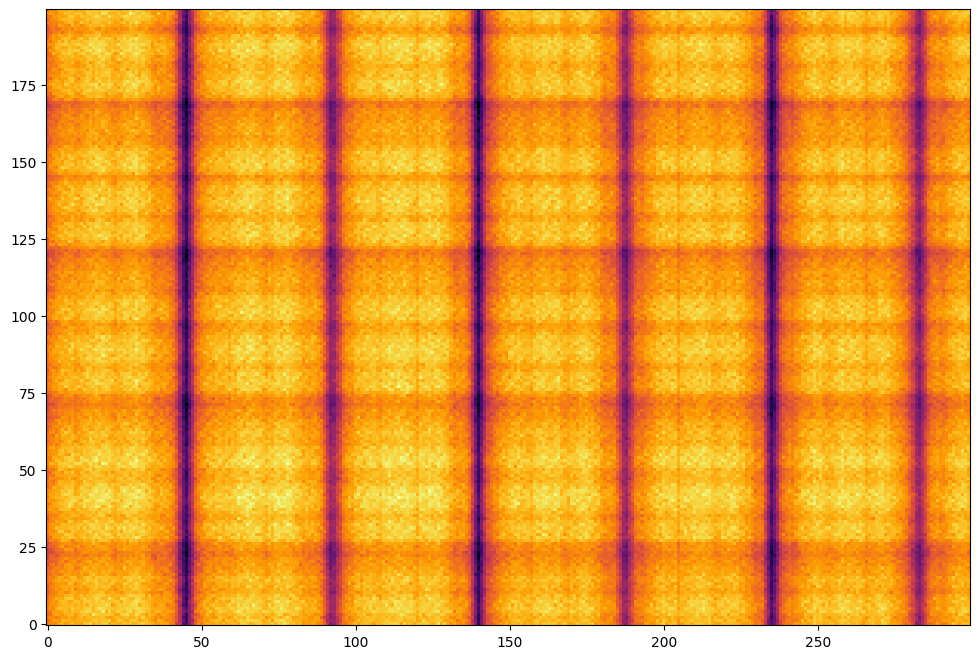

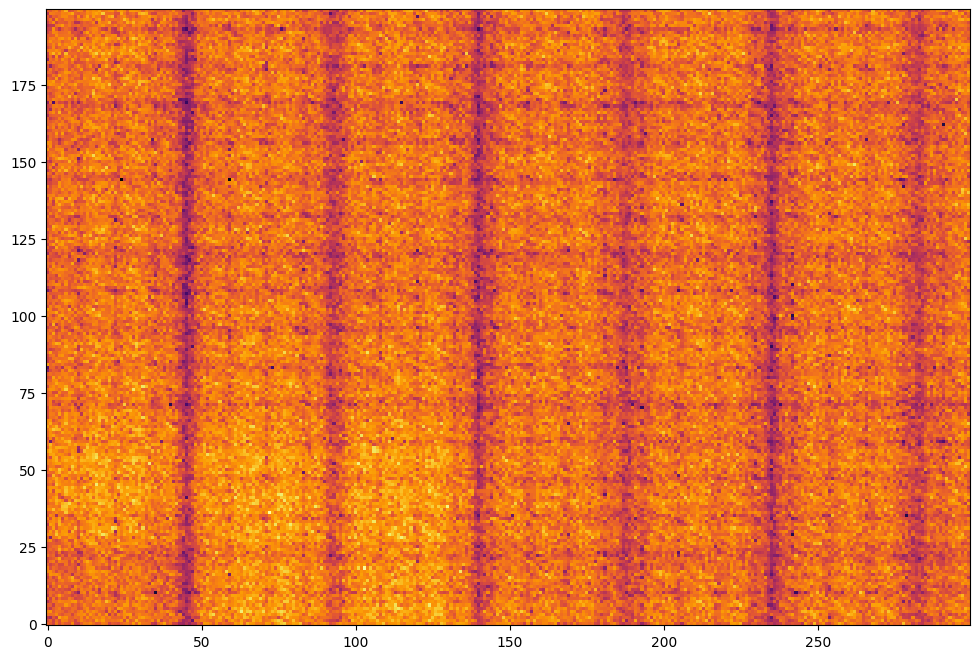

In [41]:
plt.figure(figsize=(12,8))
plt.imshow(fft_corr.transpose(), cmap='inferno', origin="lower")
plt.show()
plt.figure(figsize=(12,8))
plt.imshow(full_data.transpose(), cmap='inferno', origin="lower")
plt.show()

In [215]:
np.sqrt(np.mean((fft_corr-full_data)**2))/(np.max(obs_full)-np.min(obs_full))

ndarray(0.00164026)

[1/2] binning data...


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 19.40it/s]


[2/2] creating image...
[1/2] binning data...


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 144.86it/s]


[2/2] creating image...


(0.0, 300.0)

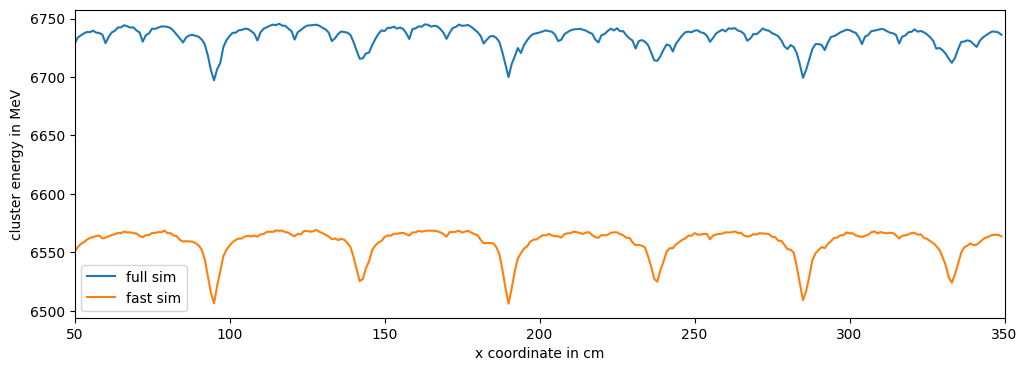

In [45]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_preds = make_img(X_full, 4*preds+6*670, params)
x_profile_obs = make_img(X_full, obs_full, params)
#x_profile_fast= make_img(X_fast, obs_fast, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
#plt.plot(x_profile_fast)
plt.plot(x_profile_preds)
plt.xlabel("x coordinate in cm")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim", "fast sim", "FT corrections"])
locs, labels = plt.xticks()
labels = [int(item+50) for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
#plt.savefig('fftprep/plots/X_axis_comparison_full_vs_fast_vs_ft.pdf')

[1/2] binning data...


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 482.91it/s]


[2/2] creating image...


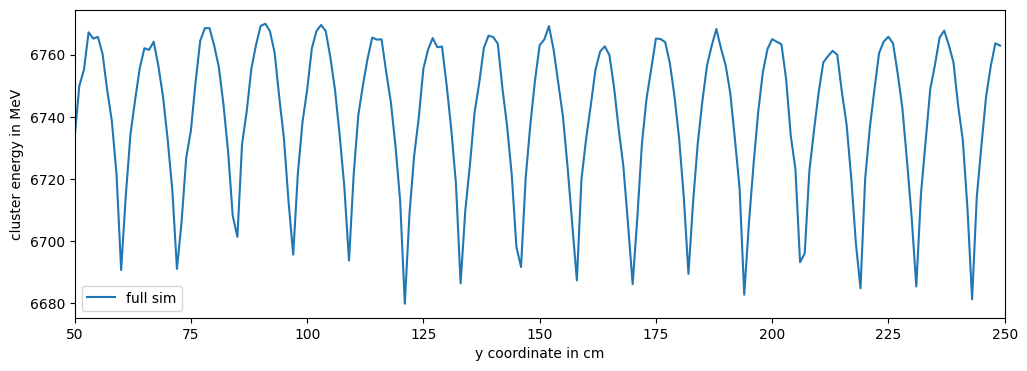

In [44]:
params = {
    "X": {
        "range": (500,3500),
        "reso": None
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.1),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
#x_profile_preds = make_img(X_full, preds, params)
x_profile_obs = make_img(X_full, obs_full, params)
#x_profile_fast= make_img(X_fast, obs_fast, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
#plt.plot(x_profile_fast)
#plt.plot(x_profile_preds)
plt.xlabel("y coordinate in cm")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim", "fast sim", "FT corrections"])
locs, labels = plt.xticks()
labels = [int(item+50) for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 200)
plt.savefig('fftprep/plots/Y_axis_comparison_full_vs_fast_vs_ft.pdf')

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 19.85it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 53.51it/s]


[2/2] creating image...
[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 39.06it/s]


[2/2] creating image...


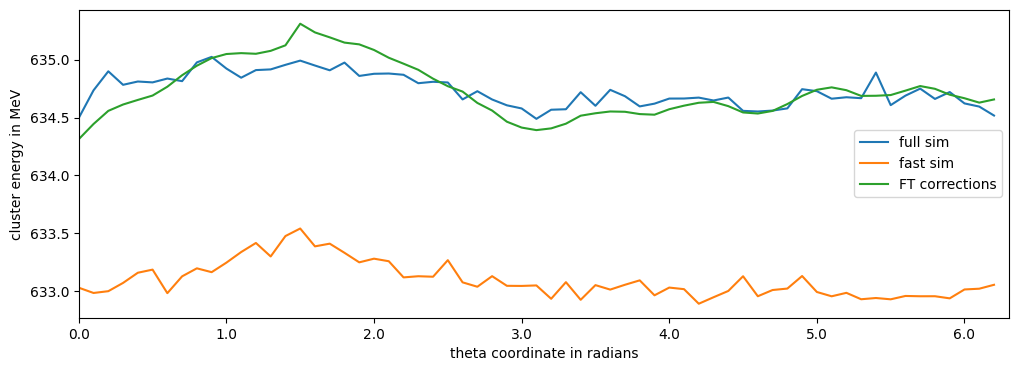

In [230]:
params = {
    "X": {
        "range": (500,3500),
        "reso": None
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (0,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": 10
    }
}
x_profile_preds = make_img(X_full, preds, params)
x_profile_obs = make_img(X_full, obs_full, params)
x_profile_fast= make_img(X_fast, obs_fast, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.plot(x_profile_fast)
plt.plot(x_profile_preds)
plt.xlabel("theta coordinate in radians")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim", "fast sim", "FT corrections"])
locs, labels = plt.xticks()
labels = [item/10 for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 63)
plt.savefig('fftprep/plots/phi_axis_comparison_full_vs_fast_vs_ft.pdf')

In [250]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.05),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
binned_preds = make_img(X_full, preds, params)
binned_obs = make_img(X_full, obs_full, params)
binned_fast= make_img(X_fast, obs_fast, params)

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 240.20it/s]


[2/2] creating image...
[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 419.50it/s]


[2/2] creating image...
[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 239.22it/s]


[2/2] creating image...


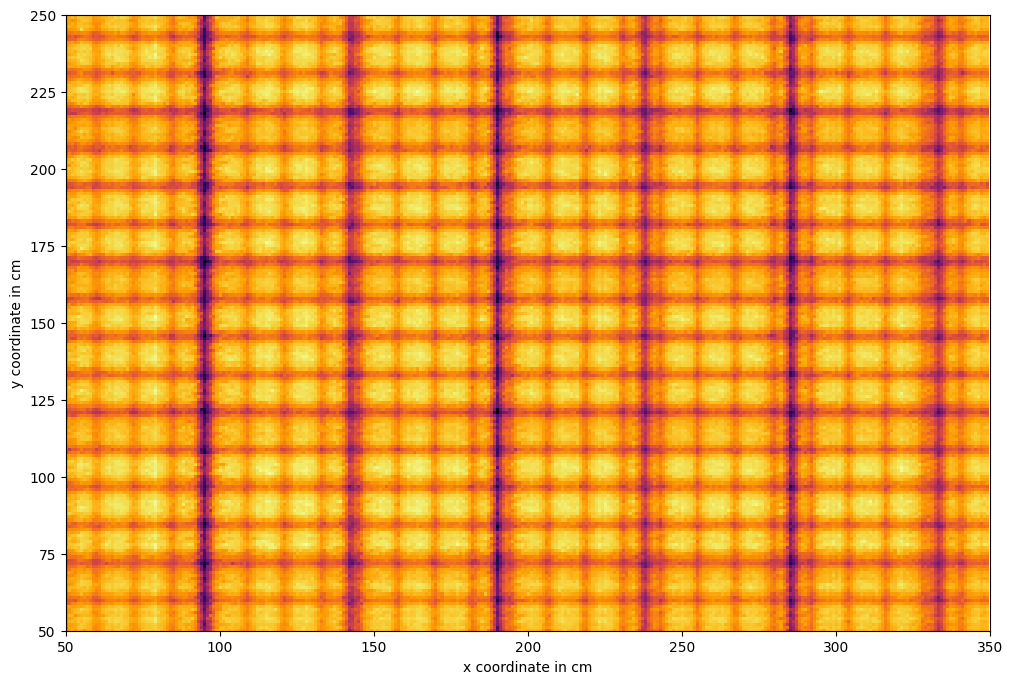

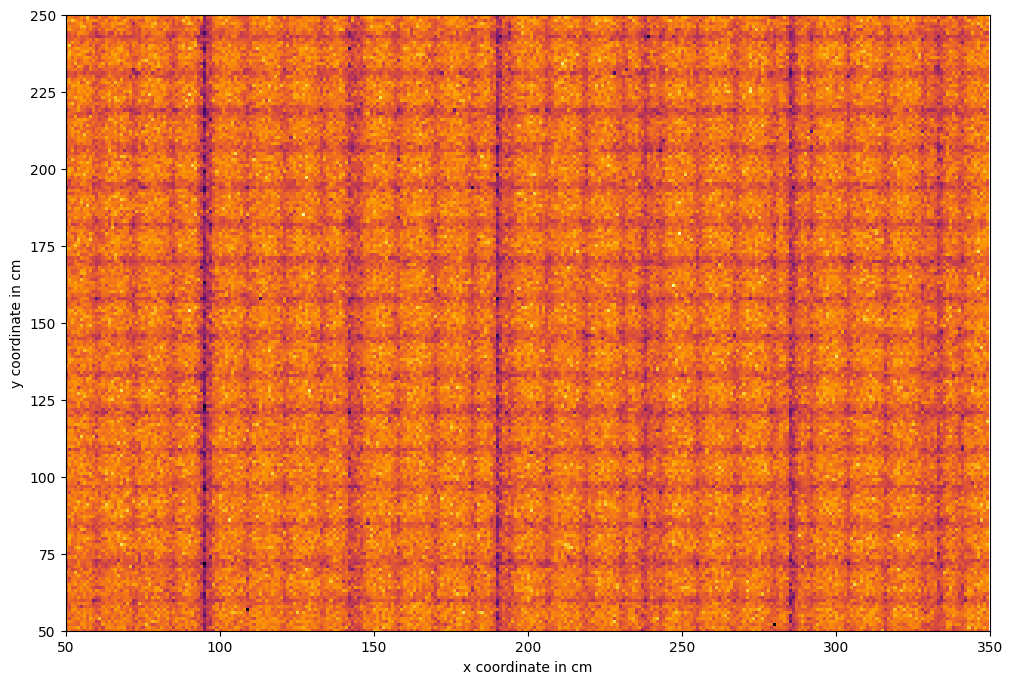

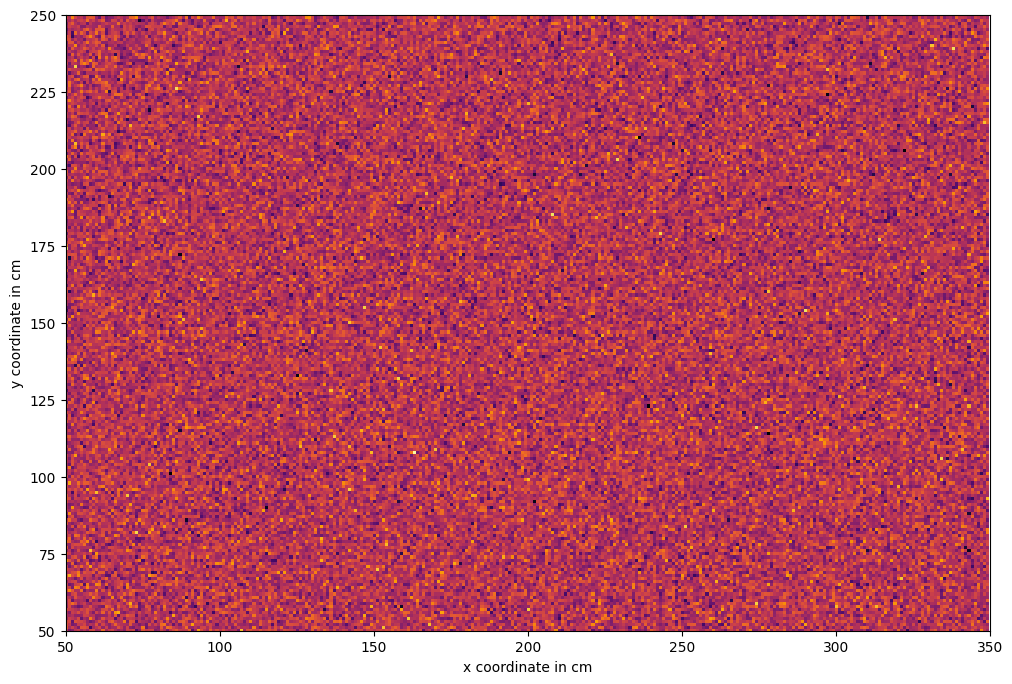

In [252]:
plt.figure(figsize=(12,8))
plt.imshow(binned_preds.transpose(), cmap='inferno', origin="lower")
locs, labels = plt.xticks()
labels = [int(item+50)for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
locs, labels = plt.yticks()
labels = [int(item+50) for item in locs]
plt.yticks(locs, labels)
plt.ylim(0, 200)
plt.xlabel("x coordinate in cm")
plt.ylabel("y coordinate in cm")
plt.savefig('fftprep/plots/XvY_ft.pdf')

plt.figure(figsize=(12,8))
plt.imshow(binned_obs.transpose(), cmap='inferno', origin="lower")
locs, labels = plt.xticks()
labels = [int(item+50)for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
locs, labels = plt.yticks()
labels = [int(item+50) for item in locs]
plt.yticks(locs, labels)
plt.ylim(0, 200)
plt.xlabel("x coordinate in cm")
plt.ylabel("y coordinate in cm")
plt.savefig('fftprep/plots/XvY_full.pdf')

plt.figure(figsize=(12,8))
plt.imshow(binned_fast.transpose(), cmap='inferno', origin="lower")
locs, labels = plt.xticks()
labels = [int(item+50)for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
locs, labels = plt.yticks()
labels = [int(item+50) for item in locs]
plt.yticks(locs, labels)
plt.ylim(0, 200)
plt.xlabel("x coordinate in cm")
plt.ylabel("y coordinate in cm")
plt.savefig('fftprep/plots/XvY_fast.pdf')

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 27.73it/s]


[2/2] creating image...


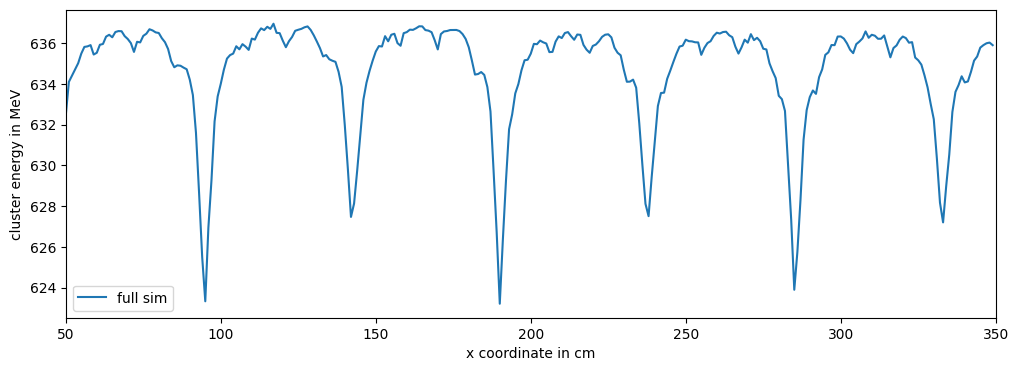

In [246]:
params = {
    "X": {
        "range": (500,3500),
        "reso": 0.1
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_obs = make_img(X_full, obs_full, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.xlabel("x coordinate in cm")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim"])
locs, labels = plt.xticks()
labels = [int(item+50) for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 300)
plt.savefig('fftprep/plots/X_axis_full.pdf')

[1/2] binning data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 134.16it/s]


[2/2] creating image...


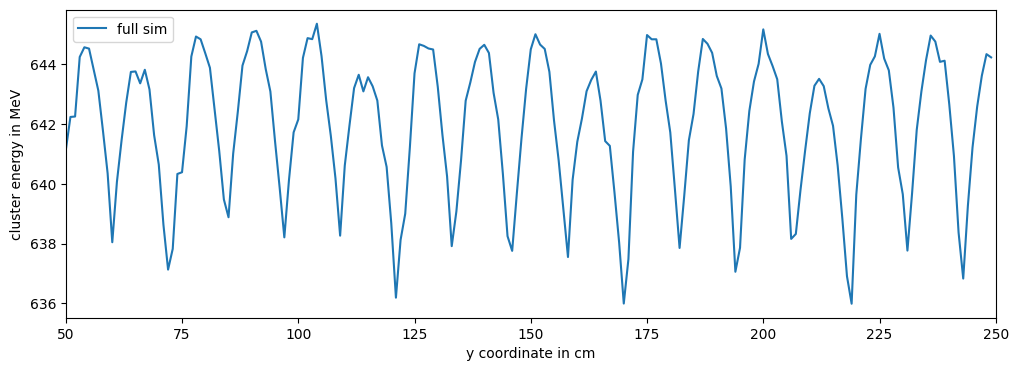

In [253]:
params = {
    "X": {
        "range": (500,3500),
        "reso": None
    }, 
    "Y": {
        "range": (500,2500),
        "reso": 0.1
    }
    , 
    "theta": {
        "range": (-1,0.1),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_obs = make_img(X_full, obs_full, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.xlabel("y coordinate in cm")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim"])
locs, labels = plt.xticks()
labels = [int(item+50) for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 200)
plt.savefig('fftprep/plots/Y_axis_full.pdf')

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 38.31it/s]


[2/2] creating image...


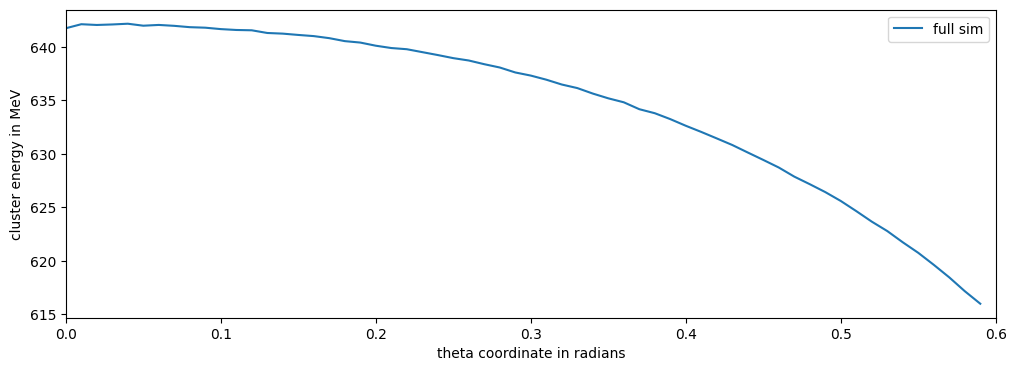

In [248]:
params = {
    "X": {
        "range": (500,3500),
        "reso": None
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": 100
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": None
    }
}
x_profile_obs = make_img(X_full, obs_full, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.xlabel("theta coordinate in radians")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim"])
locs, labels = plt.xticks()
labels = [item/100 for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 60)
plt.savefig('fftprep/plots/theta_axis_full.pdf')

[1/2] binning data...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 40.35it/s]


[2/2] creating image...


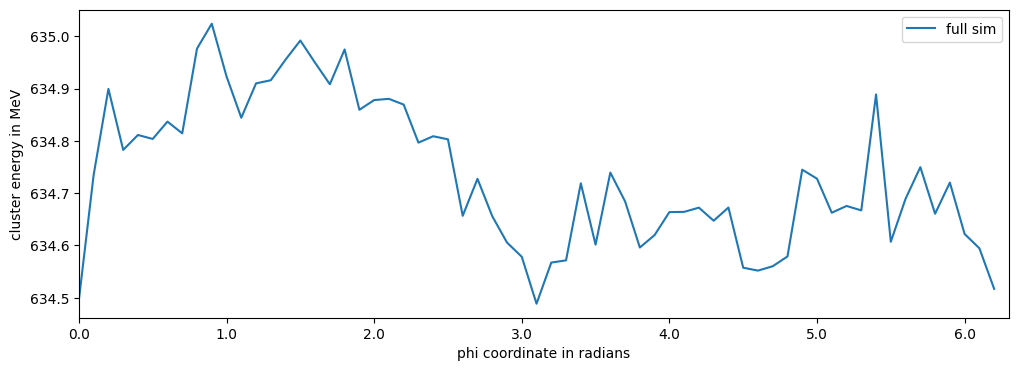

In [249]:
params = {
    "X": {
        "range": (500,3500),
        "reso": None
    }, 
    "Y": {
        "range": (500,2500),
        "reso": None
    }
    , 
    "theta": {
        "range": (-1,0.6),
        "reso": None
    }, 
    "phi": {
        "range": (-1,2*np.pi),
        "reso": 10
    }
}
x_profile_obs = make_img(X_full, obs_full, params)
plt.figure(figsize=(12,4))
plt.plot(x_profile_obs)
plt.xlabel("phi coordinate in radians")
plt.ylabel("cluster energy in MeV")
plt.legend(["full sim"])
locs, labels = plt.xticks()
labels = [item/10 for item in locs]
plt.xticks(locs, labels)
plt.xlim(0, 63)
plt.savefig('fftprep/plots/phi_axis_full.pdf')

In [208]:
def fft_filter_pairwise(data, obs, params_pairwise, n_sigma=3, make_plots=False, make_sparse=False, no_filter=False, mode="mean"):
    fft_filt_pw = {}
    for key in params_pairwise.keys():
        data_binned = make_img(data, obs, params_pairwise[key], mode=mode)
        if make_plots:
            print(f"Plotting {key}")
            print(f"{key.split("_")[0]} range is {params_pairwise[key][key.split("_")[0]]["range"]}")
            print(f"{key.split("_")[0]} bin scaling is {1 / params_pairwise[key][key.split("_")[0]]["reso"]}")
            print(f"{key.split("_")[2]} range is {params_pairwise[key][key.split("_")[2]]["range"]}")
            print(f"{key.split("_")[2]} bin scaling is {1 / params_pairwise[key][key.split("_")[2]]["reso"]}")
            fft_filt_pw[key] = fft_filter(data_binned, n_sigma=n_sigma, make_plots=True, no_filter=no_filter)
        elif make_sparse:
            fft_filt_pw[key] = fft_filter(data_binned, n_sigma=n_sigma, make_sparse=True, no_filter=no_filter)
        else:
            fft_filt_pw[key] = fft_filter(data_binned, n_sigma=n_sigma, no_filter=no_filter)
    return fft_filt_pw